In [1]:
import os, sys, json, shapely
os.environ['USE_PYGEOS'] = '0'
from datetime import date, datetime
import pandas as pd; import numpy as np; import geopandas as gpd

Sync the parquet files locally?
```bash
aws --profile=ym s3 sync s3://youthmappers-internal-us-east1/query_results/parquet/ .
```

In [6]:
DATE = '2023-12-11'

In [7]:
df = pd.read_parquet(f"parquet/ds={DATE}")
df = df.rename(columns={'_day':'day'})
df['highways']      = df['new_highways']  + df['edited_highways']
df['buildings']     = df['new_buildings'] + df['edited_buildings']
df['amenities']     = df['new_amenities'] + df['edited_amenities']
df['all_feats']     = df['new_features']  + df['edited_features']
print(f"Read {len(df):,} rows, latest ds: ", df.day.max())
print(f"Null Geometries: {len(df[pd.isnull(df.centroid)])}")
df.head(2)

Read 540,726 rows, latest ds:  2023-12-11
Null Geometries: 157


,day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,...,university,city,country,chapter_lon,chapter_lat,km_to_university,highways,buildings,amenities,all_feats
0,2023-10-17,132022202013110,b'\x01\x01\x00\x00\x00\xe9f\xdaYO\x95V@\xfcPi\...,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x08D>\x...,0,2,0,0,0,0,...,Eastern University,Dhaka,Bangladesh,90.380552,23.742501,7.678543,0,2,0,2
1,2023-10-17,032300330332223,b'\x01\x01\x00\x00\x00\x90\xd2\x11e\x14^O\xc0g...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x04\x00...,0,2,0,0,0,0,...,Sokoine University of Agriculture,Morogoro,Tanzania,37.657531,-6.852955,11332.667632,0,2,0,2


In [8]:
# Drop NULL centroid geometries
df = pd.DataFrame(df[pd.notnull(df.centroid)])

# Create geometry objects
df['geometry'] = df.centroid.apply(shapely.wkb.loads)
df['convex_hull_geom'] = df.convex_hull.apply(shapely.wkb.loads)

In [9]:
def array_to_hist(arr):
    m = dict()
    for x in arr:
        if x in m:
            m[x] += 1
        else:
            m[x] = 1
    return m

In [12]:
#Create hashtag sets and make it a GeoDataFrame:
sys.stderr.write("Processing Lists of Hashtags")
df['hashtags_hist'] = df.hashtags.apply(array_to_hist)

df = gpd.GeoDataFrame(df)

sys.stderr.write("Done\n")
df[df.hashtags_hist.apply(len)>0][['username','uid','day','hashtags_list','centroid','quadkey']].head()

Processing Lists of HashtagsDone


,username,uid,day,hashtags_list,centroid,quadkey
2,Rajendran Keerthana,13888728,2023-10-17,"{'#hotosm-project-15658': 4, '#AfghanistanEart...",b'\x01\x01\x00\x00\x00\xd64\x94\x7fR\x0eO@~\x0...,123013200010123
3,dgenesini,13862794,2023-10-17,"{'#MapPyOSM': 2, '#CIDI': 2}",b'\x01\x01\x00\x00\x00\xdb\xdd\x03t_\xddK\xc0\...,210310000323133
4,King edgar,13352087,2023-10-17,"{'#hotosm-project-15599': 1, '#GeoTE_Tanzania'...",b'\x01\x01\x00\x00\x00\xf2i\x04\xd1I(B@k\xc0{\...,300112211121221
5,samrat02,13255920,2023-10-17,"{'#hotosm-project-15127': 3, '#OSMIndia': 3, '...",b'\x01\x01\x00\x00\x00_/\xa8\xcaR\x89W@C\xf0S\...,132020323313023
7,Shrestha Shristi,13253207,2023-10-17,"{'#hotosm-project-15658': 1, '#AfghanistanEart...","b""\x01\x01\x00\x00\x00F'K\xad\xf7\x0bO@\x86n\x...",123013200010033


In [13]:
print(f"Mappers Count: {df.uid.nunique()}, Chapter count: {df.chapter.nunique()}")

Mappers Count: 2846, Chapter count: 230


In [24]:
### This is done by DuckDB Now
# Write Daily Editing CSV for Timeline: `data/daily_editing.csv`
# df.groupby('day').aggregate(
#     {'all_feats':sum,
#      'buildings':sum,
#      'highways':sum,
#      'amenities':sum,
#      'new_features':sum,
#      'uid':'nunique',
#      'chapter':'nunique'}).rolling(7).mean().to_csv(
#      '../activity-dashboard/data/daily_editing.csv'
# )

### Write JSONP Files for Chapter Index: `data/chapters_and_uids.jsonp`

In [34]:
chapters = df.drop_duplicates(subset=['chapter_id'])[['chapter','chapter_id','city','country','university']]
chapters['Chapter Name'] = chapters.chapter

with open('chapters_and_uids.jsonp','w') as outFile:
    outFile.write( 'var chapters = ' + json.dumps(
        chapters.sort_values(by='chapter').to_dict(orient='records'))+"\n")
    
chapters.head(1)

,chapter,chapter_id,city,country,university,Chapter Name
0,YouthMappers at Eastern University,66,Dhaka,Bangladesh,Eastern University,YouthMappers at Eastern University


In [16]:
sys.stderr.write("Quantifying All Hashtags...")
TAG_COUNTS = {}
for x in df.hashtags_list:
    for y in x:
        if y in TAG_COUNTS:
            TAG_COUNTS[y]+=x[y]
        else:
            TAG_COUNTS[y]=x[y]
tag_counts_df = pd.DataFrame.from_dict(TAG_COUNTS,orient='index', 
  columns=['count']).sort_values(by='count', ascending=False).reset_index().rename(columns={'index':'hashtag'})
sys.stderr.write("Done.\n")
display(tag_counts_df.head())

Quantifying All Hashtags...Done.


,hashtag,count
0,#YouthMappers,65844
1,#youthmappers,55644
2,#missingmaps,52947
3,#MissingMaps,38177
4,#Imagery4socialgood,23744


# Export Files for Graphs: `monthly_activity_*.json`

In [17]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month,15))

In [18]:
_aggregations = {'new_buildings':'sum','new_highways':'sum','new_amenities':'sum', 
     'edited_buildings':'sum', 'edited_highways':'sum', 'edited_amenities':'sum',
     'uid':'nunique','chapter':'nunique'}

today      = datetime.now();
this_month = date(today.year, today.month, 1)

# All time:
monthly_activity_all_time = df[df.month < this_month].groupby('month').aggregate(_aggregations).rename(
columns={'uid':'users','chapter':'chapters'})

monthly_activity_all_time.reset_index(inplace=True)

# Write out all activity over time
monthly_activity_all_time.to_json('monthly_activity_all_time.json',orient='records')

# Write out just last 1200 days activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=1200))].to_json('monthly_activity_last_1200_days.json',orient='records')
# Write out just last year's activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=365))].to_json('monthly_activity_last_year.json',orient='records')


<Axes: >

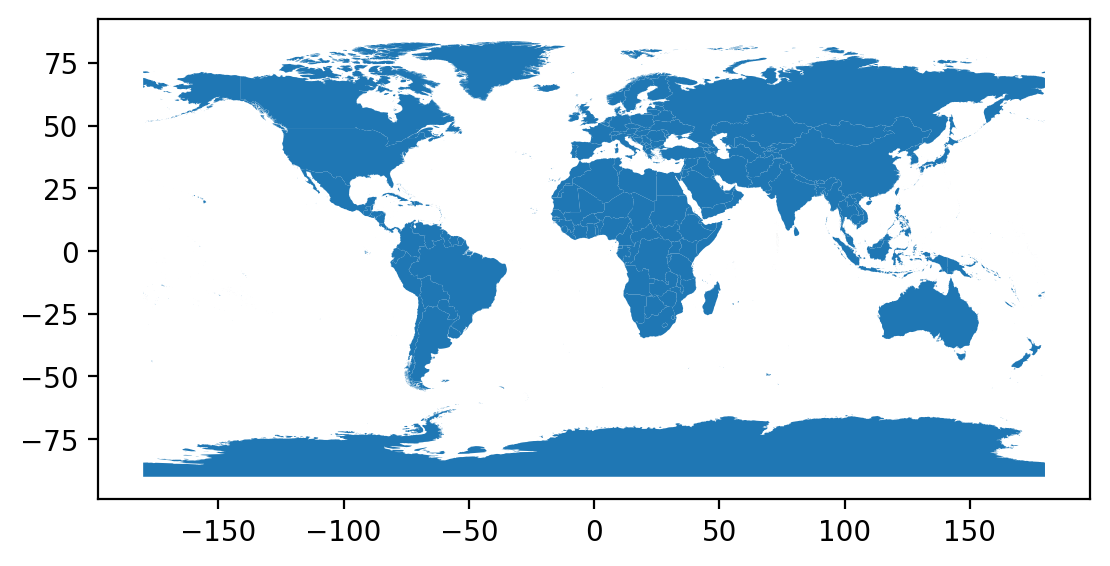

In [19]:
# Import country boundaries
countries = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')[
    ['NAME','ADM0_A3','CONTINENT','SUBREGION','geometry']
].rename(columns={'NAME':"edit_country","ADM0_A3":'edit_A3',"CONTINENT":'edit_continent','SUBREGION':'edit_subregion'})

countries.plot()

In [20]:
df_ = df.set_crs('EPSG:4326').sjoin(countries)
df_.head()

,day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,...,geometry,convex_hull_geom,hashtags_list,hashtags_hist,month,index_right,edit_country,edit_A3,edit_continent,edit_subregion
0,2023-10-17,132022202013110,b'\x01\x01\x00\x00\x00\xe9f\xdaYO\x95V@\xfcPi\...,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x08D>\x...,0,2,0,0,0,0,...,POINT (90.33297 23.79609),"LINESTRING (90.3328014 23.7959949, 90.333135 2...",{},{},2023-10-15,127,Bangladesh,BGD,Asia,Southern Asia
273,2023-10-16,132022202102233,b'\x01\x01\x00\x00\x00\x8fs\xf6)\xa2\x98V@\xc9...,b'\x01\x01\x00\x00\x00\x8fs\xf6)\xa2\x98V@\xc9...,0,0,0,0,0,0,...,POINT (90.38490 23.73495),POINT (90.3848977 23.7349548),{},{},2023-10-15,127,Bangladesh,BGD,Asia,Southern Asia
395,2023-10-15,132022202011102,b'\x01\x01\x00\x00\x00\x15\xe0\xbb\xcd\x1b\x94...,b'\x01\x01\x00\x00\x00\x15\xe0\xbb\xcd\x1b\x94...,0,43,3,2,3,1,...,POINT (90.31420 23.87203),POINT (90.314197 23.8720331),"{'#osmbd': 1, '#hotosm': 1, '#hot': 1, '#mapbd...","{'#osmbd': 1, '#hotosm': 1, '#hot': 1, '#mapbd...",2023-10-15,127,Bangladesh,BGD,Asia,Southern Asia
552,2023-10-14,132022202102233,b'\x01\x01\x00\x00\x00\xb9Qd\xad\xa1\x98V@\x82...,b'\x01\x01\x00\x00\x00\xb9Qd\xad\xa1\x98V@\x82...,0,0,0,0,0,0,...,POINT (90.38487 23.73493),POINT (90.384868 23.7349276),{},{},2023-10-15,127,Bangladesh,BGD,Asia,Southern Asia
768,2023-10-13,132022202102233,b'\x01\x01\x00\x00\x00\r<R\xd8\xa0\x98V@\xe9Nf...,b'\x01\x01\x00\x00\x00\r<R\xd8\xa0\x98V@\xe9Nf...,0,0,0,0,0,0,...,POINT (90.38482 23.73487),POINT (90.3848172 23.7348701),{},{},2023-10-15,127,Bangladesh,BGD,Asia,Southern Asia


# Export Top Edited Countries: `top_edited_countries.json`

In [22]:
top_edited_countries = []

for month, rows in df_[df_.month > this_month - pd.Timedelta(days=90)].groupby('month'):
    t15 = rows.groupby('edit_country').aggregate({'all_feats':'sum'}).sort_values(by='all_feats',ascending=False).head(15)
    
    top_edited_countries.append({'month': month.isoformat(), 'top_countries': list(zip(list(t15.index), list(t15.all_feats)))})
    
json.dump(top_edited_countries, open('top_edited_countries.json','w'))
          

In [23]:
# Which chapters are active in the most edited countries?
top_country = top_edited_countries[-1].get('top_countries')[0][0]
df_[df_.edit_country==top_country].groupby('chapter').aggregate(
    {'uid':'nunique','all_feats':'sum'}
        ).sort_values(by='all_feats', ascending=False).head()

,uid,all_feats
chapter,,
YouthMappers at University of Dar es Salaam,24,207458
SMCoSE YouthMappers,45,162867
IRDP YouthMappers Dodoma,30,114708
YouthMappers Dhaka College,12,97509
YouthMappers at IRS,6,58682


In [28]:
# top_chapters = df_[df_.day > date(2022,1,1)].groupby('edit_continent').aggregate(
#     {'all_feats':'sum'}).sort_values(by='all_feats', ascending=False).head(5).index.values
# top_chapters

array(['Africa', 'Asia', 'South America', 'North America', 'Europe'],
      dtype=object)

### Local Editing?

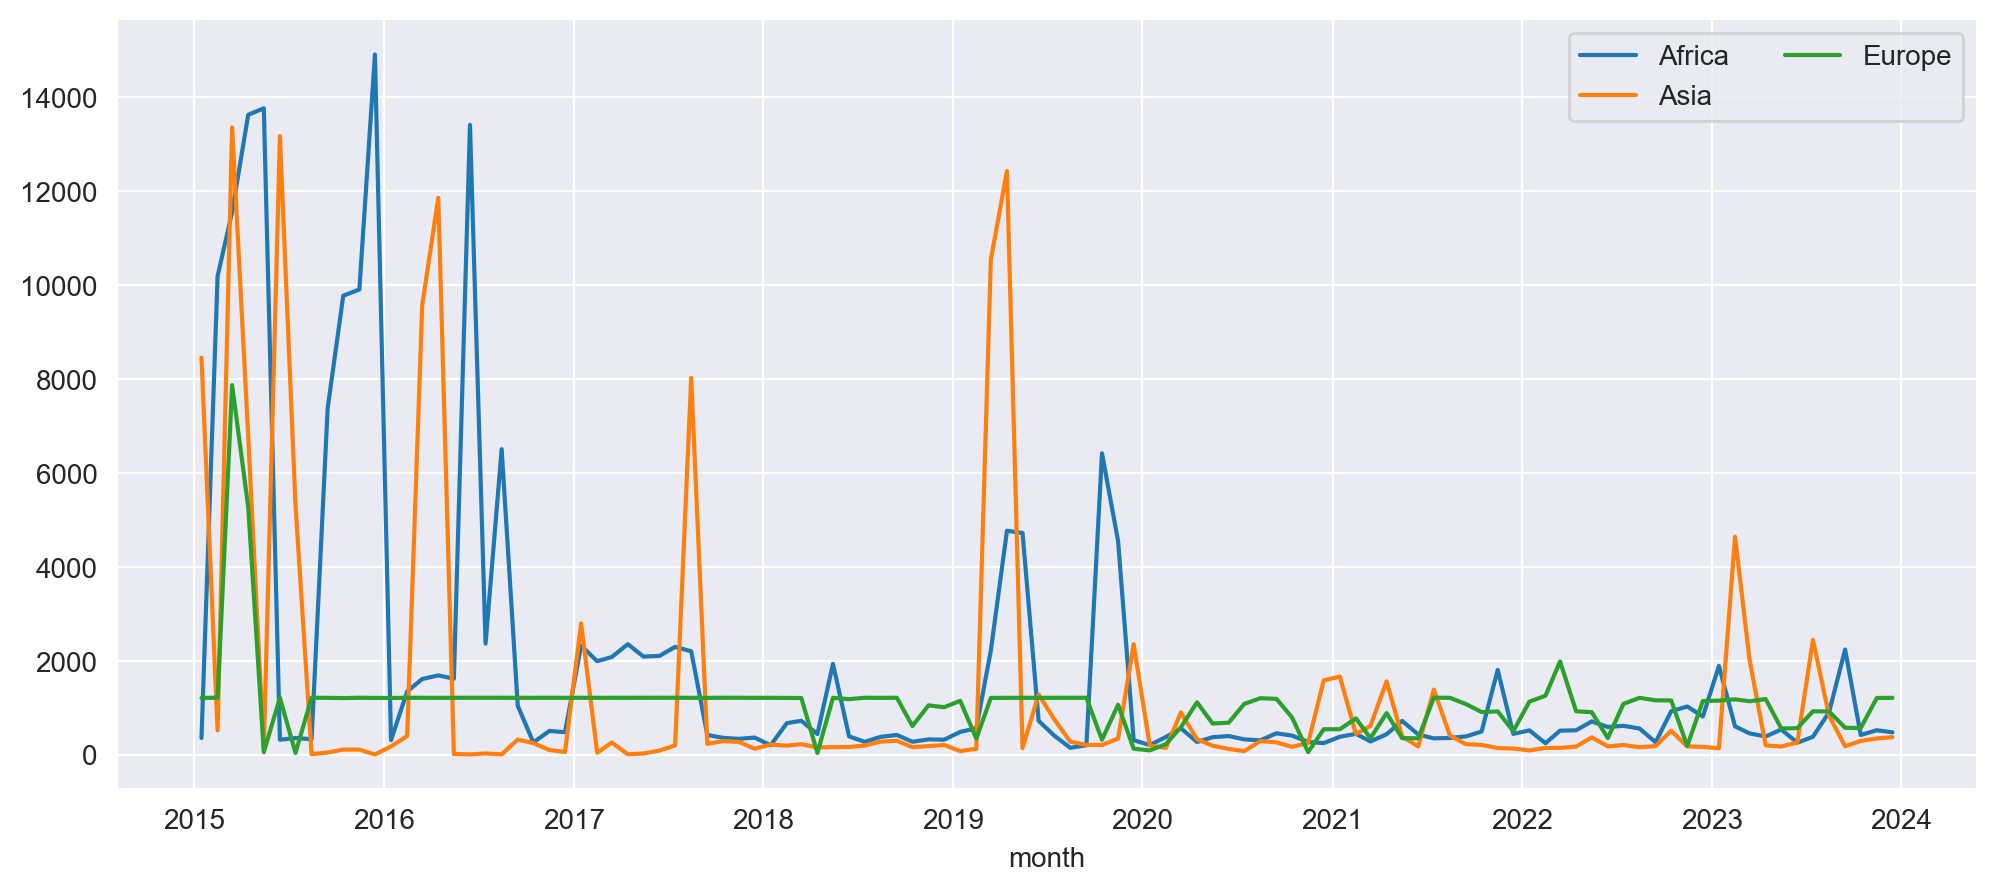

In [29]:
import seaborn as sns
sns.set_style("darkgrid")
ax = df_.groupby(['month','edit_continent']).aggregate(
    {'km_to_university':'median'}
).unstack().km_to_university[
    ['Africa','Asia','Europe']].plot(figsize=(12,5))
ax.legend(loc='best',ncol=2)
ax.set_ylabel("Median distance (km) from home\nUniversity that YouthMappers are editing.", fontsize=16)
ax.set_ylabel(None);

<br>
<br>
<hr>

# MEL Reporting Requirements

In [ ]:
df_['month'] = df_.day.apply(lambda d: date(d.year, d.month, 15))
df.head(2)

In [ ]:
df_.gender = df_.gender.fillna('').apply(lambda s: s.lower())

In [ ]:
gb_month_gender = df_[df_.gender != ''].groupby(['month','gender']).aggregate({
    'uid':'nunique', 
    'chapter_id':'nunique',
    'highways':sum, 
    'buildings':sum,
    'amenities':sum, 
    'all_feats':sum 
})

gb_month_gender.unstack().uid.plot.area(stacked=True, lw=0, figsize=(15,8))
                                           

In [ ]:
gb_month_gender.rename(columns={'uid':'mappers','chapter_id':'chapters'}).to_csv('mappers_per_month_with_gender.csv')

<br><br>
<hr>
<br><br>

# Summary Stats and Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [ ]:
df.hashtags_list = df.hashtags_list.apply(set)

In [ ]:
print("Overall, our dataset contains {:,} known YouthMapper usernames from {:,} chapters that have made at least 1 edit in OSM".format(
    df.uid.nunique(), df.chapter.nunique())
)

## Time Bounded

In [ ]:
START_DATE  = pd.Timestamp('2022-01-01')
END_DATE    = pd.Timestamp('2023-01-01')

In [ ]:
_slice = df[ (df.day >= START_DATE) & 
             (df.day  < END_DATE) ]
print("In this time slice, we saw:\n\t{:,} Distinct YouthMappers from \n\t{:,} Chapters".format(
    _slice.uid.nunique(),_slice.chapter.nunique()))
first_edits = df.groupby('uid').aggregate({'day':min}).reset_index()
print("\t{} of these mappers made their first edit.".format(len(
    first_edits[(first_edits.day >= START_DATE) & (first_edits.day < END_DATE)])))

In [ ]:
print("New Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.new_buildings.sum(), _slice.new_highways.sum(), _slice.new_amenities.sum(),
    _slice.new_features.sum() - (_slice.new_buildings.sum()+_slice.new_highways.sum()+_slice.new_amenities.sum())))
print("===========================")
print("Edited Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.edited_buildings.sum(), _slice.edited_highways.sum(), _slice.edited_amenities.sum(),
    _slice.edited_features.sum() - (_slice.edited_buildings.sum()+_slice.edited_highways.sum()+_slice.edited_amenities.sum())))
# print("\nDeleted Objects:   {:,}".format(_slice.deleted_features.sum()))

## Top Chapters

In [ ]:
top_chaps = _slice.groupby('chapter').aggregate(
    {'uid':'nunique',
     'new_features': sum,
     'edited_features': sum,
     'sum_edits': sum,
     'changeset_count': sum,
     'all_feats': sum,
     'highways': sum,
     'buildings': sum,
     'amenities': sum}).sort_values(by='all_feats', ascending=False).rename(
    columns={'uid':"Mappers"})
top_chaps.to_csv('mapper_data/2022_statistics.csv')

top_chaps.sum()

## Per Continent Stats?

In [ ]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_._day>datetime(2018,1,1,0,0,0))
        ].groupby('_day').aggregate({'uid':'nunique'}).sort_index().rolling(7).mean().plot(figsize=(10,4))
ax.set_title("Active YouthMappers editing in African Countries since 2018", fontsize=16)
ax.set_ylabel("Daily Mappers\n(7-day rolling average)", fontsize=14); ax.set_xlabel(None);

In [ ]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_._day>datetime(2018,1,1,0,0,0))
        ].groupby('_day').aggregate({'all_feats':sum}).sort_index().cumsum().plot(figsize=(10,4))
ax.set_title("Features edited within African countries by YouthMappers since 2018", fontsize=16)
ax.set_ylabel("OSM Features edited", fontsize=14); ax.set_xlabel(None);
ax.yaxis.set_major_formatter(lambda x, pos: "{} Million".format(int(x/1000000)))
ax.set_ylim(1,10000000);

In [ ]:
print("Top 15 Countries by New Features Count")
aggregators = {'new_features':sum,'new_buildings':sum, 'new_highways':sum, 'new_amenities':sum, 
        'edited_features':sum, 'chapter':'nunique', 'uid':'nunique'}
_slice.groupby('country').aggregate(aggregators
    ).sort_values(by='new_features',ascending=False).head(15).rename(columns={'chapter':"# Chapters",'uid':"# Mappers"})


In [ ]:
ax = _slice.plot(column='new_features',cmap='viridis', figsize=(15,8), s=np.log1p(_slice.all_feats))
ax.set_title("Edit Concentration this quarter")

In [ ]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month, 15))
gb_month = df.groupby('month').aggregate(aggregators)

In [ ]:
sns.set_style('darkgrid')
ax = gb_month['new_features'].plot(figsize=(15,8))
ax.set_title("New Features Added Each Month (Globally)", fontsize=20)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(lambda x, pos: "{:,}".format(int(x)))

In [ ]:
sns.set_style('darkgrid')
ax = gb_month['edited_features'].plot(figsize=(15,8))
ax.set_title("Features Edited Each Month (Globally)", fontsize=20)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(lambda x, pos: "{:,}".format(int(x)))

In [ ]:
_slice.edited_buildings.sum(), _slice.new_buildings.sum()

In [ ]:
_slice.chapter.unique()

In [ ]:
days_per_mapper = df.groupby('uid').aggregate({'day':'nunique'}).reset_index()
active_contributors = days_per_mapper[days_per_mapper.day>=42].uid

print("There are {} _active contributors_ in YouthMappers (mapped for at least 42 days)".format(len(active_contributors)))
print("{} of these mappers were active in this time slice".format(_slice[_slice.uid.isin(active_contributors)].uid.nunique()))

In [ ]:
by_subregion = _slice.groupby('subregion').aggregate(
    {'uid':'nunique','chapter':'nunique','all_feats':sum}
).sort_values(by='all_feats',ascending=False).rename(
    columns={'uid':"YouthMappers",'chapter':"Chapters",'all_feats':'Features'})
by_subregion.head(15)

In [ ]:
df['year'] = df.day.apply(lambda d: d.year)
df.head(2)

In [ ]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month, 1))

In [ ]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'chapter':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Chapters Active Each Month", fontsize=24)

In [ ]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'uid':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Mappers Active Each Month", fontsize=24)

In [ ]:
with open('changesets_by_year.geojson','w') as outFile:
    outFile.write(df[['year','centroid','all_feats','username']].to_json())

In [ ]:
# Top Edited Countries by User count: 
hashtags_used = _slice.groupby('chapter').aggregate({'uid':'nunique',
                                     'country':'nunique',
                                     'all_feats':sum,
                                     'hashtags_list':lambda a: set.union(*a)}
    ).sort_values(by='all_feats',ascending=False).rename(columns={
         'uid':'Mappers','country':'Countries Edited','all_feats':'Total features'})
hashtags_used['Distinct Hashtags Used'] = hashtags_used.hashtags_list.apply(len)
hashtags_used.head(10)

In [ ]:
country_geoms = gpd.read_file('/Users/jenningsanderson/various-osm/data/countries.geojson').set_index('ADMIN')

In [ ]:
# Top Edited Countries by feature
countries = _slice.groupby('country').aggregate(
        {'all_feats':'sum','chapter':set}
).sort_values(by='all_feats',ascending=False)
display(countries.head(10))
list(countries.head(2).chapter)

In [ ]:
countries

In [ ]:
from matplotlib import colors

In [ ]:
country_geoms.join(countries).plot(column='all_feats', cmap='Greens', figsize=(15,10))

In [ ]:
country_geoms.join(countries).plot(column='all_feats', cmap='Greens', figsize=(15,10), 
                                   norm=colors.LogNorm(vmin=countries.all_feats.min(), vmax=countries.all_feats.max(), ))

In [ ]:
_slice[_slice.country=='Afghanistan'].groupby('chapter').aggregate({'all_feats':sum}).sort_values(by='all_feats',ascending=False)

In [ ]:
hashtags = _slice[_slice.country=='Afghanistan'].groupby('chapter').aggregate(
    {'all_feats':sum, 'hashtags_list':lambda a: set.union(*a)
}).sort_values(by='all_feats',ascending=False)
hashtags.head()

In [ ]:
list(hashtags.hashtags_list)

In [ ]:
with open('2021_q2.geojson','w') as output:
    output.write(_slice[['highways','buildings','amenities','all_feats','sum_edits','uid','chapter','centroid','timestamp']].to_json())